In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from scipy.fft import fft, ifft, fftfreq

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = True

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

MessageError: ignored

In [ ]:
print(os.getcwd())

In [ ]:
from tools.misc_tools import RK4_integrator

In [ ]:
def create_KS_data(x_grid, delta_x, T, delta_t, L_int, init_cond, lmda=1.0, mu=0.0, nu=1.0):
    # tder = np.empty_like(init_cond)
    
    totalnumtsteps = int((T+0.1*delta_t)//delta_t)
    length = L_int*lmda
    M = len(x_grid)
    
    all_data = np.empty(shape=(totalnumtsteps+1, x_grid.shape[0]))
    all_data[0, :] = init_cond[:]
    
    freq_idx_arr = np.array(fftfreq(M)*M, dtype=np.int32)
    # scalars for ETDRK4
    h = delta_t
    k = fftfreq(M) * M * 2*np.pi/length
    L = k**2 - k**4
    E = np.exp(h*L)
    E_2 = np.exp(h*L/2)
    Q = 0
    phi1 = 0.0
    phi2 = 0.0
    phi3 = 0.0


    M_Cauchy = 32 #number of evaluation points in Cauchy integral

    for j in range(1,M_Cauchy+1):

        arg = h*L + np.ones(L.shape[0]) * np.exp(2j*np.pi*(j-0.5)/M_Cauchy)

        phi1 += 1.0/arg * (np.exp(arg) - np.ones(L.shape[0]))
        phi2 += 1.0/arg**2 * (np.exp(arg) - arg - np.ones(L.shape[0]))
        phi3 += 1.0/arg**3 * (np.exp(arg) - 0.5*arg**2 - arg - np.ones(L.shape[0]))
        Q += 2.0/arg * (np.exp(0.5*arg) - np.ones(L.shape[0]))

    phi1 = np.real(phi1/M_Cauchy)
    phi2 = np.real(phi2/M_Cauchy)
    phi3 = np.real(phi3/M_Cauchy)
    Q = np.real(Q/M_Cauchy)

    f1 = phi1 - 3*phi2 + 4*phi3 #-4 - L * h + E * (4 - 3 * L * h + (L * h)*(L * h))
    f2 = 2*phi2 - 4*phi3 #2 + L * h + E * (-2 + L * h)
    f3 = -phi2 + 4*phi3 #-4 - 3 * L * h - (L*h)*(L*h) + E * (4 - L*h)

    # main loop
    v = fft(init_cond)
    for i in range(1, totalnumtsteps+1):

        Nv = -0.5j*k * fft(np.real(ifft(v))**2)
        a = E_2 * v + h/2 * Q * Nv
        Na = -0.5j*k * fft(np.real(ifft(a))**2)
        b = E_2 * v + h/2 * Q * Na
        Nb = -0.5j*k * fft(np.real(ifft(b))**2)
        c = E_2 * a + h/2 * Q * (2 * Nb - Nv)
        Nc = -0.5j*k * fft(np.real(ifft(c))**2)
        #update rule
        v = E * v + h*f1*Nv + h*f2*(Na+Nb) + h*f3*Nc

        #save data
        all_data[i, :] = np.real(ifft(v))
    

    res_dict = {'all_data':all_data}
    return res_dict

In [ ]:
lmda = 2
L_int = 20

L = L_int*lmda

# delta_x = 1
# xgrid_numpoints = 1+int( (L_int*lmda+0.1*delta_x)//delta_x )

xgrid_numpoints = 128
delta_x = L / (xgrid_numpoints-1)

delta_t = 0.01
x_grid = L*np.linspace(0, 1, xgrid_numpoints)
# init_cond = -np.sin(5*np.pi*x_grid/x_grid[-1])
init_cond = np.cos(2*np.pi*x_grid/L)*(1+np.sin(2*np.pi*x_grid/L))
T = 200

In [ ]:
res_dict = create_KS_data(x_grid, delta_x, T, delta_t, L_int, init_cond, lmda)

In [ ]:
all_data = res_dict['all_data']

In [ ]:
# all_data

In [ ]:
idx_arr = np.where(np.isnan(all_data) == True)
print(idx_arr[0])

[]


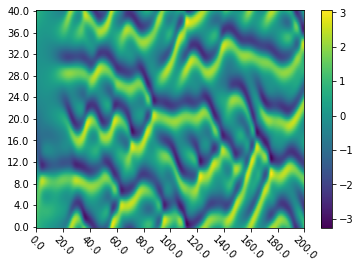

In [ ]:
if idx_arr[0].shape[0] != 0:
    plt.imshow(all_data[0:idx_arr[0][0]-int(0/delta_t)].transpose(), aspect='auto', origin='lower')
else:
    plt.imshow(all_data.transpose(), aspect='auto', origin='lower')
numtsteps = int( (T+0.1*delta_t)//delta_t )
xticks = np.linspace(0, numtsteps, 1+10, dtype=np.int32 )
plt.xticks(xticks, xticks*T/numtsteps, rotation=270+45)

# yticks = x_grid.copy()*len(x_grid)/x_grid[-1]
yticks = np.linspace(0, 1, 10+1)*(len(x_grid)-1)
yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*x_grid[-1], 2)

plt.yticks(yticks, yticklabels)
plt.colorbar()
plt.show()